In [1]:
import json
import networkx as nx
with open('./football.vidi_r.json') as fp:
    graph = json.load(fp)

In [2]:
indexedNodes = {}
clusters = []
for node in graph['nodes']:
    indexedNodes[node['idx']] = node
    indexedNodes[node['idx']]['size'] = 1

In [23]:
origin_graph = nx.Graph()
for node in graph['nodes']:
    if not node['virtualNode']:
        origin_graph.add_node(node['idx'])
for edge in graph['links']:
    origin_graph.add_edge(edge['sourceIdx'], edge['targetIdx'])

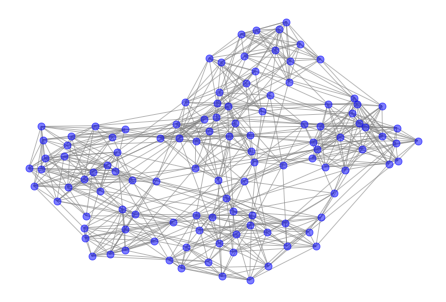

In [38]:
nx.draw(origin_graph, node_size=50, with_labels=False, node_color="blue", alpha=0.5, edge_color="gray")

In [3]:
hierarchy_sorted_levels = sorted([int(i) for i in graph['hierarchy'].keys()])

In [4]:
# elimate nodes with too few childrew(less than 3)
nodeIndexes = sorted(indexedNodes.keys())
for nid in nodeIndexes:
    node = indexedNodes[nid]
    if not node['ancIdx']:
        continue
    # not-leaves node but have children less than 3
    if node['virtualNode'] and len(node['childIdx']) < 3:
        ancNode = indexedNodes[node['ancIdx']]
        ancNodeChildren = set(ancNode['childIdx'])
        ancNodeChildren.remove(nid)
        
        for cid in node['childIdx']:
            indexedNodes[cid]['ancIdx'] = ancNode['idx']
            ancNodeChildren.add(cid)

        ancNode['childIdx'] = list(ancNodeChildren)
        del indexedNodes[nid]

In [5]:
# refine height for every node
# top-down
queue = [graph['rootIdx']]
indexedNodes[graph['rootIdx']]['height'] = 0
minHeight = 0
while len(queue) > 0:
    nid = queue.pop(0)
    nHeight = indexedNodes[nid]['height']
    for c in indexedNodes[nid]['childIdx']:
        indexedNodes[c]['height'] = nHeight - 1
        queue.append(c)
    if len(indexedNodes[nid]['childIdx']) > 0:
        if nHeight - 1 < minHeight:
            minHeight = nHeight - 1
maxHeight = abs(minHeight)
for i, node in indexedNodes.items():
    node['height'] += maxHeight

In [6]:
# build hierarchy
hierarchy = {}
for i in range(maxHeight + 1):
    hierarchy[i] = []
for i, node in indexedNodes.items():
    hierarchy[node['height']].append(i)

In [7]:
def get_ancestor_chain(nid, indexedNodes, explore_list):
    if indexedNodes[nid]['ancIdx']:
        explore_list.append(indexedNodes[nid]['ancIdx'])
        return get_ancestor_chain(indexedNodes[nid]['ancIdx'], indexedNodes, explore_list)
    else:
        return explore_list

for i, node in indexedNodes.items():
    if not node['virtualNode']:
        node['ancestors'] = get_ancestor_chain(i, indexedNodes, [])

In [8]:
# Least Common Ancestor
def get_LCA(source, target, indexedNodes):
    sourceList = indexedNodes[source]['ancestors']
    targetList = set(indexedNodes[target]['ancestors'])
    for a in sourceList:
        if a in targetList:
            return a
    return None

In [9]:
# construct links in quotient graphs
linksInNodes = {}
for link in graph['links']:
    lca = get_LCA(link['sourceIdx'], link['targetIdx'], indexedNodes)
    if lca not in linksInNodes:
        linksInNodes[lca] = {}
    source = link['sourceIdx']
    target = link['targetIdx']
    for i in indexedNodes[source]['ancestors']:
        if i == lca:
            break
        else:
            source = i
    for i in indexedNodes[target]['ancestors']:
        if i == lca:
            break
        else:
            target = i
    if (source, target) not in linksInNodes[lca]:
        linksInNodes[lca][(source, target)] = 0
    linksInNodes[lca][(source, target)] += 1

In [10]:
# construct quotient graphs
# bottom-up construct quotient graphs and compute size for each node
import networkx as nx
from functools import reduce
import math
quotientGraphs = {}
k = 5
for l, nodes in hierarchy.items():
    if l == 0:
        continue
    for nidx in nodes:
        node = indexedNodes[nidx]
        g = nx.Graph()
        for c in node['childIdx']:
            g.add_node(c, size=indexedNodes[c]['size'])
        links = linksInNodes[nidx]
        for link, weight in links.items():
            g.add_edge(link[0], link[1], weight=weight)
        size = 0
        for n in g.nodes():
            size +=  g.nodes[n]['size'] * g.nodes[n]['size']
        indexedNodes[nidx]['size'] = math.sqrt(5 * size)
        quotientGraphs[nidx] = g

In [15]:
quotientGraphs

{115: <networkx.classes.graph.Graph at 0x1e6a3b18748>,
 116: <networkx.classes.graph.Graph at 0x1e6a3b18708>,
 117: <networkx.classes.graph.Graph at 0x1e6a3b18788>,
 118: <networkx.classes.graph.Graph at 0x1e6a3b187c8>,
 119: <networkx.classes.graph.Graph at 0x1e6a3b0a208>,
 120: <networkx.classes.graph.Graph at 0x1e6a3b188c8>,
 121: <networkx.classes.graph.Graph at 0x1e6a3b18908>,
 122: <networkx.classes.graph.Graph at 0x1e6a3b18948>,
 123: <networkx.classes.graph.Graph at 0x1e6a3b18988>,
 124: <networkx.classes.graph.Graph at 0x1e6a3b189c8>,
 125: <networkx.classes.graph.Graph at 0x1e6a3b18a08>,
 126: <networkx.classes.graph.Graph at 0x1e6a3b18a48>,
 137: <networkx.classes.graph.Graph at 0x1e6a3b18a88>}

In [45]:
# layout for every quotient graph
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=True,  # Prevent overlap
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)
for idx, g in quotientGraphs.items():
    print(idx)
    print(g)
    try:
        positions = forceatlas2.forceatlas2_networkx_layout(quotientGraphs[idx], pos=None, iterations=2000)
    except ZeroDivisionError:
        positions = nx.spring_layout(quotientGraphs[idx])
    g.layout = positions
G = quotientGraphs[126]
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
nx.draw_networkx_nodes(G, positions, node_size=20, with_labels=False, node_color="blue", alpha=0.4)
nx.draw_networkx_edges(G, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

115



100%|██████████| 2000/2000 [00:00<00:00, 29406.47it/s]
BarnesHut Approximation took0.01 seconds
Repulsion forces took0.03 seconds
Gravitational forces took0.00 seconds
Attraction forces took0.01 seconds
AdjustSpeedAndApplyForces step took0.01 seconds
116



100%|██████████| 2000/2000 [00:00<00:00, 25968.27it/s]
BarnesHut Approximation took0.01 seconds
Repulsion forces took0.03 seconds
Gravitational forces took0.01 seconds
Attraction forces took0.01 seconds
AdjustSpeedAndApplyForces step took0.01 seconds
117



  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:00<00:00, 18514.51it/s]
BarnesHut Approximation took0.01 seconds
Repulsion forces took0.05 seconds
Gravitational forces took0.00 seconds
Attraction forces took0.02 seconds
AdjustSpeedAndApplyForces step took0.02 seconds
118



  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:00<00:00, 17090.21it/s]
BarnesHut Approximation took0.02 seconds
Repulsion forces took0.06 seconds
Gravi

ZeroDivisionError: float division

In [ ]:
# test a layout
test_graph = quotientGraphs[116]
positions = test_graph.layout
nx.draw_networkx_nodes(test_graph, positions, node_size=20, with_labels=False, node_color="blue", alpha=0.4)
nx.draw_networkx_edges(test_graph, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

In [ ]:
print(positions)
print(indexedNodes[1])

In [ ]:
# 2D version layout
# Top-down
root = graph['rootIdx']
indexedNodes[root]['Pos2D'] = (0, 0)
def layout_by_quotient_graph(nid, indexedNodes):
    if not indexedNodes[nid]['virtualNode']:
        return 
    size = indexedNodes[nid]['size']
    x = indexedNodes[nid]['Pos2D'][0]
    y = indexedNodes[nid]['Pos2D'][1]
    r_list = [ math.sqrt(pos[0] * pos[0] + pos[1] * pos[1]) for i, pos in quotientGraphs[nid].layout.items() ]
    max_radius = max(r_list)
    scaling_ratio = float(size) / max_radius
    for c in indexedNodes[nid]['childIdx']:
        dx = quotientGraphs[nid].layout[c][0]
        dy = quotientGraphs[nid].layout[c][1]
        indexedNodes[c]['Pos2D'] = (x + dx * scaling_ratio, y + dy * scaling_ratio)
        layout_by_quotient_graph(c, indexedNodes)

layout_by_quotient_graph(root, indexedNodes)

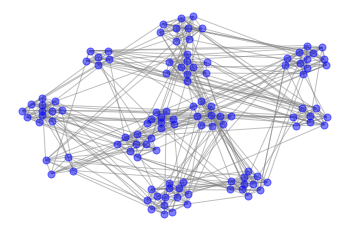

In [49]:
position_2d = {}
for i, node in indexedNodes.items():
    if not node['virtualNode']:
        position_2d[node['idx']] = node['Pos2D']
nx.draw_networkx_nodes(origin_graph, position_2d, node_size=50, with_labels=False, node_color="blue", alpha=0.5)
nx.draw_networkx_edges(origin_graph, position_2d, edge_color="gray", alpha=0.5)
plt.axis('off')
plt.show()

In [56]:
# import numpy as np
posX = np.array([positions[i][0] for i in positions])
posY = np.array([positions[i][1] for i in positions])
maxX = posX.max()
minX = posX.min()
maxY = posY.max()
minY = posY.min()

In [57]:
# Clamp y to [0, Pi]
# Clamp x to [-pi, pi]
sPositions = {}
sx = []
sy = []
sz = []
for i, c in positions.items():
    x = (c[0] - minX) * np.pi / (maxX - minX) 
    y = -0.7 * (c[1] - minY) * np.pi / (maxY - minY)
    sx.append(np.sin(y) * np.cos(x))
    sy.append(np.sin(y) * np.sin(x))
    sz.append(np.cos(y))
    sPositions[i] = [sx[-1], sy[-1], sz[-1]]

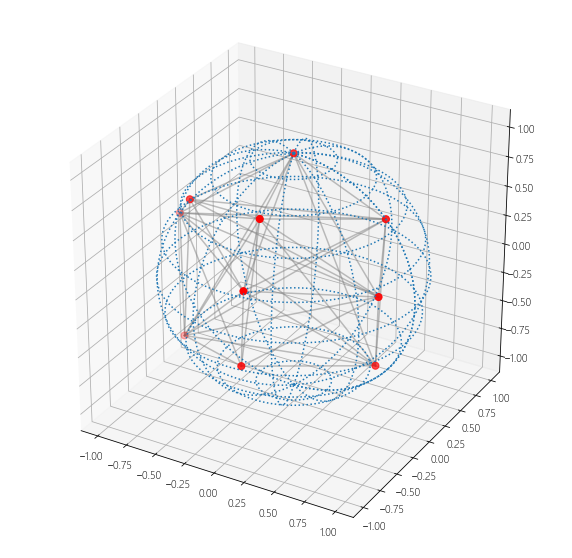

In [58]:
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(sx, sy, sz, c='r', s=50)

# center and radius
center = [0, 0, 0]
radius = 1

# data
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = radius * np.outer(np.cos(u), np.sin(v)) + center[0]
y = radius * np.outer(np.sin(u), np.sin(v)) + center[1]
z = radius * np.outer(np.ones(np.size(u)), np.cos(v)) + center[2]

for e in G.edges():
    p1 = sPositions[e[0]]
    p2 = sPositions[e[1]]
    ax.plot([p1[0],p2[0]],[p1[1], p2[1]],[p1[2], p2[2]],color = 'gray', alpha=0.5)

ax.plot_wireframe(x, y, z, rstride=10, cstride=10, linestyle=':')

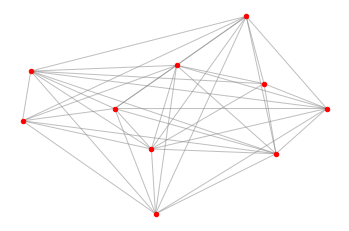

In [45]:
nx.draw_networkx_nodes(G, positions, node_size=20, with_labels=False, node_color="r", alpha=1)
nx.draw_networkx_edges(G, positions, edge_color="gray", alpha=0.5)
plt.axis('off')
plt.show()

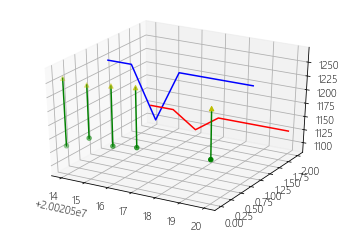

In [9]:
import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D

dates       = [20020514, 20020515, 20020516, 20020517, 20020520]
highs       = [1135, 1158, 1152, 1158, 1163]
lows        = [1257, 1253, 1259, 1264, 1252]
upperLimits = [1125.0, 1125.0, 1093.75, 1125.0, 1125.0]
lowerLimits = [1250.0, 1250.0, 1156.25, 1250.0, 1250.0]

zaxisvalues0= [0, 0, 0, 0, 0]
zaxisvalues1= [1, 1, 1, 1, 1]
zaxisvalues2= [2, 2, 2, 2, 2]

fig = matplotlib.pyplot.figure()
ax  = fig.add_subplot(111, projection = '3d')

ax.plot(dates, zaxisvalues1, lowerLimits, color = 'b')
ax.plot(dates, zaxisvalues2, upperLimits, color = 'r')

for i,j,k,h in zip(dates,zaxisvalues0,lows,highs):
    ax.plot([i,i],[j,j],[k,h],color = 'g')

ax.scatter(dates, zaxisvalues0, highs, color = 'g', marker = "o")
ax.scatter(dates, zaxisvalues0, lows, color = 'y', marker = "^")

matplotlib.pyplot.show()

In [10]:
np.sin(np.pi / 2)

1.0